# A/B-тестирование для проверки динамики платежной активности

# Содержание

**Часть 0: Описание задачи
<br>
<br>
Часть 1: Проверка корректности данных
<br>
<br>
Часть 2: Анализ равномерности и валидности распределения юзеров по группам
<br>
<br>
Часть 3: Анализ результатов эксперимента
<br>
<br>
Часть 4: Заключение**

# Часть 0: Описание задачи

Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах
<br>
<br>
1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?
<br>
2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?
<br>
3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?
<br>
<br>
Описание данных:
<br>
<br>
В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
<br>
tag - лэйбл группы (control - контрольная, остальные - тестовые)
<br>
ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
<br>
user_uid - внутренний id юзера (для матчинга со второй таблицей)
<br>
registration_time - время регистрации пользователя в сервисе
<br>
conv_ts - время совершения первой покупки пользователем в сервисе
<br>
<br>
В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
<br>
user_uid - внутренний id юзера (для матчинга со второй таблицей)
<br>
time - время совершения транзакции
<br>
consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
<br>
element_uid - уникальный id единицы контента или подписки
<br>
price - цена (преобразованная)
<br>
<br>
Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.

# Часть 1: Проверка корректности данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
users = pd.read_csv('users_.csv')
users

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019
...,...,...,...,...,...
696977,test3,30135.048875,e10d8044e619248ed68e54bc9f78efa9,27410.028612,27640.573832
696978,test2,30144.864583,75c4da27fde4db78cf7e92e1847d1661,27410.037686,29293.210971
696979,test4,30157.801078,d679d86c76c03f86e1459bde6b582664,27410.050534,29633.843281
696980,test4,30140.139148,ca7d91f45bcc7eed9402a781e48cd6f5,27410.114820,27448.255112


In [389]:
users.ts.nunique()

696500

In [390]:
pd.to_datetime(users['ts']).nunique()

27

Переводить данные в формат времени не имеет смысла - теряются уникальные значения

In [391]:
users.dtypes

tag                   object
ts                   float64
user_uid              object
registration_time    float64
conv_ts              float64
dtype: object

In [392]:
users.nunique()

tag                       5
ts                   696500
user_uid             694819
registration_time    690641
conv_ts                2893
dtype: int64

In [393]:
users.groupby('user_uid').agg({'tag': 'nunique'}).tag.value_counts()

1    693358
2      1437
3        23
4         1
Name: tag, dtype: int64

У нас есть 1461 пользователь, которым одновременно присвоено 2, 3 и даже 4 тэга. Это пересечение, таких пользователей надо удалить из датасета. Они в сумме занимают 0.2% от общего числа юзеров.

In [7]:
with_1_tag = []
[with_1_tag.append(i) for i in users.groupby('user_uid', as_index=False).agg({'tag': 'nunique'}).query("tag != 1").user_uid]
len(with_1_tag)

1461

In [8]:
users = users.query("user_uid not in @with_1_tag")
users.shape

(694011, 5)

In [396]:
users.nunique()

tag                       5
ts                   693534
user_uid             693358
registration_time    689211
conv_ts                2893
dtype: int64

In [397]:
users.query("registration_time > ts")

,tag,ts,user_uid,registration_time,conv_ts
1308,control,30132.530282,509b44822a9ec9b6f96c01d118176faf,30244.874660,30046.187656
14137,test3,30144.708921,1cd7770bba07ac2dd5152751b5ac5aac,30238.227555,30142.347016
28157,test1,30132.469814,d6d1be3a09a0ca4bf42988176477d3df,30243.051099,29793.565608
28947,test1,30150.216191,b5bb0bd4fc9f3731f824dc854349706b,30246.250068,29831.051460
37621,test1,30140.000534,c5101de8fdfb1e3cc551e525f32e2a93,30245.979976,NaN
...,...,...,...,...,...
658315,control,30156.679669,a6522659b4767c3ba4c633b488859c31,30245.829571,NaN
672977,test1,30135.189462,cfcde41c21342d9c832c98ce94dfa206,30157.210560,29430.115823
678593,test4,30158.349019,bb4a90d22d55de54544108cf0bd11ec5,30201.924673,30155.385573
691061,control,30133.983285,5a2f92f89f349fb4565f5dc4d4ff09db,30236.433278,27531.375915


В датасете 141 человек (0.02% от всех пользователей), у которого дата регистрации меньше даты присвоения тэга. Исключим их

In [9]:
ts_before_reg = []
[ts_before_reg.append(i) for i in users.query("registration_time > ts").user_uid]
users = users.query("user_uid not in @ts_before_reg")

In [10]:
users.shape

(693870, 5)

In [400]:
users.groupby('user_uid').agg({'registration_time': 'nunique'}).registration_time.value_counts()

1    692744
0       473
Name: registration_time, dtype: int64

In [401]:
users.groupby('user_uid').agg({'ts': 'nunique'}).ts.value_counts()

1    692582
2       617
3        18
Name: ts, dtype: int64

In [402]:
users.groupby('user_uid').agg({'conv_ts': 'nunique'}).conv_ts.value_counts()

1    692975
0       242
Name: conv_ts, dtype: int64

В выборке есть юзеры, по которым произошли дубли - их 635 (0.09% от выборки). Им присваивались одни и те же тэги, но более одного раза в разные даты. Удалим их

In [11]:
duplicates_list = []
[duplicates_list.append(i) for i in users.groupby('user_uid', as_index=False).agg({'ts': 'nunique'}).query("ts > 1").user_uid]
users = users.query("user_uid not in @duplicates_list")

In [12]:
users.shape

(692582, 5)

In [405]:
users.nunique()

tag                       5
ts                   692105
user_uid             692582
registration_time    688443
conv_ts                2887
dtype: int64

Предобработка датасета users закончена. Перейдем к таблице purchases

In [4]:
purchases = pd.read_csv('purchases_.csv')
purchases

,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.470588
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.588235
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.352941
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.470588
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.470588
...,...,...,...,...,...
663844,b95eb8746f20dba6ddc804a382b0763a,30106.491242,rent,f17e9ea5412551ddb4b258595413f98c,26.823529
663845,facc4c49dd6e6bccd77be41845297f2a,30106.491145,dto,0ccd083bb2e44eeed4d6e2b6ca86a480,44.470588
663846,f81a8bf7f6d136108da82dcf0b8e1141,30106.491129,rent,7bbdee0cb298b62ab4766241d2fb477d,26.823529
663847,0ffbe5d7a89472510b757f4c674c3b4d,30106.491029,dto,5aa724c0393087cde3a18c625b310645,21.058824


In [5]:
purchases.dtypes

user_uid             object
time                float64
consumption_mode     object
element_uid          object
price               float64
dtype: object

In [407]:
purchases.isna().sum()

user_uid            0
time                0
consumption_mode    0
element_uid         0
price               0
dtype: int64

In [408]:
purchases.drop_duplicates().shape

(663849, 5)

Таблица purchases не содержит пропусков и дубликатов, форматы данных корректные

In [13]:
users.query("ts < conv_ts and ts < registration_time") \
    .merge(purchases[['user_uid', 'time', 'consumption_mode']], how='left', on='user_uid')

,tag,ts,registration_time,conv_ts,user_uid,time,consumption_mode


В датасете нет юзеров, у которых время присвоения тега произошло до регистрации и до первой покупки

Теперь данные корректные, с ними можно работать

# Часть 2: Анализ равномерности и валидности распределения юзеров по группам

Теперь посмотрим на равномерность и валидность выборок

In [410]:
users.tag.value_counts(normalize=True)

test1      0.200977
test2      0.199985
test4      0.199793
test3      0.199793
control    0.199452
Name: tag, dtype: float64

В каждой из 5 групп находится примерно 20% трафика, соответственно распределение юзеров примерно одинаковое

In [14]:
df = users.merge(purchases, on='user_uid', how='left')

Отберем данные, отражающие период до начала проведения A/B-теста - тех, у кого время покупки меньше времени присвоения лейбла, а так же тех, кто зарегистрировался до начала тестирования и при этом ничего не купил

In [412]:
df.ts.min()

30132.31051184637

In [15]:
df_before = df.query("time < ts or registration_time < 30132.31051184637 and time.isnull()")
df_before

,tag,ts,user_uid,registration_time,conv_ts,time,consumption_mode,element_uid,price
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691,NaN,NaN,NaN,NaN
3,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30125.717420,dto,a693322f7dbc21d5064c06021b878597,35.647059
4,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30122.544398,dto,80fd3378dfc91b30d85cc0bd05a37993,35.647059
5,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30118.725912,rent,80fd3378dfc91b30d85cc0bd05a37993,25.647059
6,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30118.626008,rent,a693322f7dbc21d5064c06021b878597,25.647059
...,...,...,...,...,...,...,...,...,...
1058732,test2,30144.864583,75c4da27fde4db78cf7e92e1847d1661,27410.037686,29293.210971,NaN,NaN,NaN,NaN
1058733,test4,30157.801078,d679d86c76c03f86e1459bde6b582664,27410.050534,29633.843281,NaN,NaN,NaN,NaN
1058734,test4,30140.139148,ca7d91f45bcc7eed9402a781e48cd6f5,27410.114820,27448.255112,NaN,NaN,NaN,NaN
1058738,test4,30135.493437,23f24586aaddd9229c724fac4725c94f,27410.140327,29017.771448,30115.869255,rent,f623271b7ba61393790e9ab8cec839d4,25.647059


Посмотрим на **средний чек** - отличается ли он по выборкам

In [415]:
df_before.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'avg_check'})

,tag,avg_check
0,control,35.981236
1,test1,35.907625
2,test2,35.868327
3,test3,35.875315
4,test4,35.951459


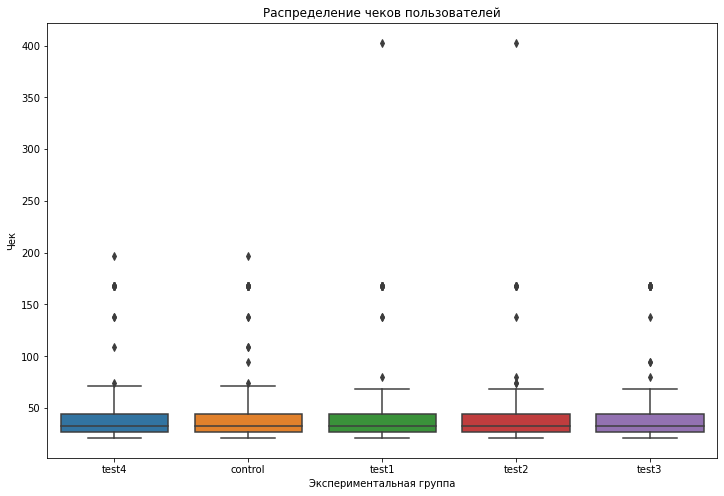

In [19]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df_before, x='tag', y='price')
ax.set(title='Распределение чеков пользователей')
ax.set(xlabel='Экспериментальная группа', ylabel='Чек')
var = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

<Figure size 1152x864 with 0 Axes>

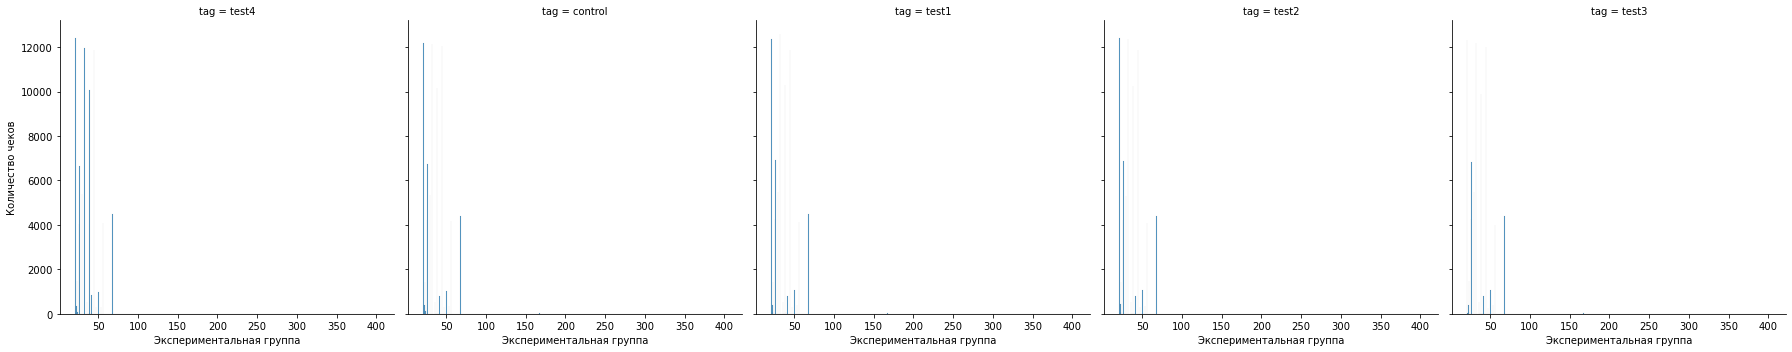

In [37]:
plt.figure(figsize=(16,12))
ax = sns.displot(df_before, x='price', col='tag')
ax.set(xlabel='Экспериментальная группа', ylabel='Количество чеков')

Распределение визуально отличается от нормального. Попробуем нормализовать распределение чеков с помощью логарифмирования

[Text(0.5, 1.0, 'Распределение логарифмированных чеков')]

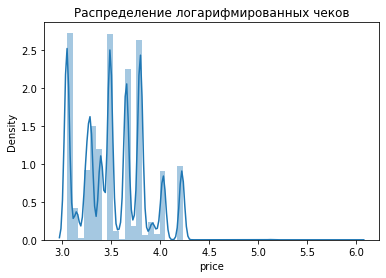

In [51]:
ax = sns.distplot(np.log(df_before.price))
ax.set(title='Распределение логарифмированных чеков')

In [29]:
df_before['log_price'] = np.log(df_before['price'])

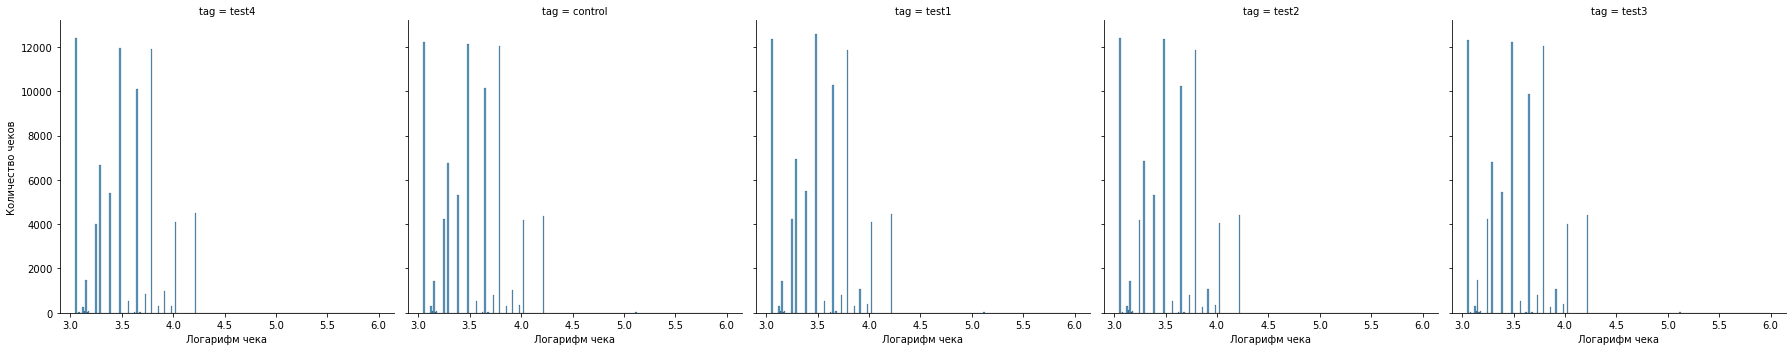

In [36]:
ax = sns.displot(df_before, x='log_price', col='tag')
ax.set(xlabel='Логарифм чека', ylabel='Количество чеков')

Распределения визуально явно отличаются от нормальных. Проведем статистический тест, чтобы удостовериться

In [173]:
from scipy import stats

In [422]:
stats.shapiro(df_before.query("tag == 'control' and price > 0").price.sample(1000, random_state=17))

ShapiroResult(statistic=0.8639017343521118, pvalue=1.4301203450635087e-28)

In [423]:
stats.shapiro(df_before.query("tag == 'test1' and price > 0").price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9032914638519287, pvalue=1.2183044560716866e-24)

In [424]:
stats.shapiro(df_before.query("tag == 'test2' and price > 0").price.sample(1000, random_state=17))

ShapiroResult(statistic=0.89411860704422, pvalue=1.184106596273257e-25)

In [425]:
stats.shapiro(df_before.query("tag == 'test3' and price > 0").price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9014635682106018, pvalue=7.556734283307507e-25)

In [426]:
stats.shapiro(df_before.query("tag == 'test4' and price > 0").price.sample(1000, random_state=17))

ShapiroResult(statistic=0.8951545357704163, pvalue=1.5285534660742788e-25)

Распределения для всех групп значимо отличаются от нормального

In [428]:
stats.levene(df_before.query("tag == 'control'  and price > 0").price,
            df_before.query("tag == 'test1'  and price > 0").price,
            df_before.query("tag == 'test2'  and price > 0").price,
            df_before.query("tag == 'test3'  and price > 0").price,
            df_before.query("tag == 'test4'  and price > 0").price)

LeveneResult(statistic=1.6332167128309865, pvalue=0.16273365510890075)

Требование к гомогенности дисперсий соблюдается. Тем не менее используем непараметрический тест Краскела-Уоллиса из-за ненормальности распределения

In [430]:
stats.kruskal(df_before.query("tag == 'control' and price > 0").price,
            df_before.query("tag == 'test1' and price > 0").price,
            df_before.query("tag == 'test2' and price > 0").price,
            df_before.query("tag == 'test3' and price > 0").price,
            df_before.query("tag == 'test4' and price > 0").price)

KruskalResult(statistic=4.626326833626191, pvalue=0.3278300422446007)

Пи-велью выше альфы (0.05), значит не можем отвергнуть гипотезу об отсутствии различий. 
<br>
**Распределение по среднему чеку равномерно**

Посмотрим на **конверсию** в предпериоде

In [431]:
df_before['converted'] = np.where(df_before['time'] > 0, 1, 0)

In [432]:
df_before.nunique()

tag                       5
ts                   625606
user_uid             625988
registration_time    622839
conv_ts                2887
time                 383102
consumption_mode          3
element_uid            5999
price                    46
log_price                46
converted                 2
dtype: int64

In [433]:
df_before_conv = df_before.groupby('user_uid', as_index=False).agg({'tag': 'max', 'converted': 'max'})
df_before_conv.groupby('tag').agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,conversion
tag,
control,0.367001
test1,0.370298
test2,0.367373
test3,0.366753
test4,0.365984


In [191]:
from scipy.stats import chi2_contingency, chi2 

In [434]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_before_conv.tag, df_before_conv.converted))
stat, p

(5.909481751909995, 0.20601098322831232)

**Конверсии статистически не отличаются. Распределение равномерно и валидно**

# Часть 3: Анализ результатов эксперимента

Метрики, на которые стоит обратить внимание:
- конверсия в транзакцию, 
- конверсия в каждый тип транзакции (покупка, аренда, подписка), 
- конверсия в повторную покупку,
- средний чек, 
- ARPU, 
- ARPPU, 

Посмотрим на **конверсию**

Оставим данные по тем юзерам, которые совершили транзакцию после присвоения тега, а также тех, кто не совершил транзакции (вне зависимости от времени регистрации, так как зарегестрировавшиеся до начала эксперимента могли сконвертироваться в ходе теста)

In [32]:
df_after = df.query("time > ts or time.isnull()")
df_after

,tag,ts,user_uid,registration_time,conv_ts,time,consumption_mode,element_uid,price
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691,NaN,NaN,NaN,NaN
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30147.939441,rent,f1ed5620d661f7d604e31509f3542504,25.647059
2,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734,30133.782798,subscription,dd7f3f7b10fb9b502cbc5d1a9abc067b,50.352941
7,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899,NaN,NaN,NaN,NaN
8,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226,30138.171910,subscription,6044f6995c3da1720dd814bafe3b2349,38.588235
...,...,...,...,...,...,...,...,...,...
1058733,test4,30157.801078,d679d86c76c03f86e1459bde6b582664,27410.050534,29633.843281,NaN,NaN,NaN,NaN
1058734,test4,30140.139148,ca7d91f45bcc7eed9402a781e48cd6f5,27410.114820,27448.255112,NaN,NaN,NaN,NaN
1058735,test4,30135.493437,23f24586aaddd9229c724fac4725c94f,27410.140327,29017.771448,30158.432323,rent,059253ab01a83ccc0d90aa4147ecb11f,26.823529
1058736,test4,30135.493437,23f24586aaddd9229c724fac4725c94f,27410.140327,29017.771448,30140.484255,dto,783002315b28940b5f249dcacc3a9d00,26.823529


In [33]:
df_after['converted'] = np.where(df_after['time'] > 0, 1, 0)

In [437]:
df_after_conv = df_after.groupby('user_uid', as_index=False).agg({'tag': 'max', 'converted': 'max'})
df_after_conv.groupby('tag').agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,conversion
tag,
control,0.272493
test1,0.282117
test2,0.279162
test3,0.279821
test4,0.279887


In [438]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.tag, df_after_conv.converted))
stat, p

(29.039865897309706, 7.672962636732087e-06)

Конверсии статистически значимо отличаются. Посмотрим, в каких группах есть это различие - проведем попарные сравнения. Но так как при попарных сравнениях растет вероятность ошибки первого рода - применим поправку Бонферони (для каждой пары стат значимость различий подтверждается не при p-value ниже альфы 0.05, а при p-value ниже альфы, деленной на кол-во всех попарных сравнений). Так как у нас 5 групп, то совершается 10 попарных сравнений (при этом мы будем смотреть только разницу каждого теста с контролем). Соответственно, пи-велью для каждого попарного сравнения должен быть ниже 0.005

In [439]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.query("tag == 'control' or tag == 'test1'").tag, 
                                                      df_after_conv.query("tag == 'control' or tag == 'test1'").converted))
stat, p

(25.436913641125088, 4.5708769945957217e-07)

In [440]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.query("tag == 'control' or tag == 'test2'").tag, 
                                                      df_after_conv.query("tag == 'control' or tag == 'test2'").converted))
stat, p

(12.22278423613238, 0.00047209426865192275)

In [441]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.query("tag == 'control' or tag == 'test3'").tag, 
                                                      df_after_conv.query("tag == 'control' or tag == 'test3'").converted))
stat, p

(14.753179344181333, 0.00012254072111288805)

In [442]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv.query("tag == 'control' or tag == 'test4'").tag, 
                                                      df_after_conv.query("tag == 'control' or tag == 'test4'").converted))
stat, p

(15.025860440430986, 0.00010604798801522589)

**В каждой группе конверсия выросла значимо.** В первой группе - на 3.5%, во второй группе - на 2.4%, в третьей группе - на 2.7%, в четвертой группе - на 2.7%

Посмотрим на **конверсию в повторную покупку**

In [443]:
df_after_conv2 = df_after.query("time > 0").groupby("user_uid", as_index=False).agg({'tag': 'max', 'price': 'count'})

In [444]:
df_after_conv2['converted'] = np.where(df_after_conv2['price'] > 1, 1, 0)

In [445]:
df_after_conv2.groupby('tag').agg({'converted': 'mean'}).rename(columns={'converted': 'conversion'})

,conversion
tag,
control,0.369376
test1,0.383863
test2,0.385510
test3,0.384924
test4,0.389199


In [446]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.tag, df_after_conv2.converted))
stat, p

(29.845909907981287, 5.260980308667034e-06)

Отличия значимы. Так же, как и с конверсией в первую транзакцию, сделаем попарные сравнения, помня, что уровень значимости теперь 0.005

In [447]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.query("tag == 'control' or tag == 'test1'").tag, 
                                                      df_after_conv2.query("tag == 'control' or tag == 'test1'").converted))
stat, p

(13.598667233785346, 0.0002263461635658186)

In [448]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.query("tag == 'control' or tag == 'test2'").tag, 
                                                      df_after_conv2.query("tag == 'control' or tag == 'test2'").converted))
stat, p

(16.74520865132184, 4.275008380617694e-05)

In [449]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.query("tag == 'control' or tag == 'test3'").tag, 
                                                      df_after_conv2.query("tag == 'control' or tag == 'test3'").converted))
stat, p

(15.573397445611588, 7.936338405346471e-05)

In [450]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_conv2.query("tag == 'control' or tag == 'test4'").tag, 
                                                      df_after_conv2.query("tag == 'control' or tag == 'test4'").converted))
stat, p

(25.294573525867193, 4.920912141076293e-07)

**В каждой группе конверсия в повторную транзакцию стат значимо выросла.** У первой группы - на 3.9%, у второй группы - на 4.4%, у третьей группы - на 4.3%, у четвертой - на 5.4%

Посмотрим на **конверсии в каждый тип транзакций. Начнем с покупки.**

In [451]:
df_after_dto = df_after
df_after_dto['converted'] = np.where(df_after_dto['consumption_mode'] == 'dto', 1, 0)

In [452]:
df_after_dto.groupby('user_uid', as_index=False) \
    .agg({'tag': 'max', 'converted': 'max'}) \
    .groupby('tag', as_index=False) \
    .agg({'converted': 'mean'}) \
    .rename(columns={'converted': 'conversion_dto'})

,tag,conversion_dto
0,control,0.105396
1,test1,0.116498
2,test2,0.114033
3,test3,0.115765
4,test4,0.118734


In [453]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.converted, df_after_dto.tag))
stat, p

(178.22384138762862, 1.7945965042914303e-37)

Посмотрим на различия между группами, помня, что уровень значимости теперь 0.005

In [454]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.query("tag == 'control' or tag == 'test1'").converted,
                                                      df_after_dto.query("tag == 'control' or tag == 'test1'").tag))
stat, p

(89.5106475559878, 3.049925766087801e-21)

In [455]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.query("tag == 'control' or tag == 'test2'").converted,
                                                      df_after_dto.query("tag == 'control' or tag == 'test2'").tag))
stat, p

(80.21871976552029, 3.351767047303828e-19)

In [456]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.query("tag == 'control' or tag == 'test3'").converted,
                                                      df_after_dto.query("tag == 'control' or tag == 'test3'").tag))
stat, p

(96.29386087626413, 9.903665349988011e-23)

In [457]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_dto.query("tag == 'control' or tag == 'test4'").converted,
                                                      df_after_dto.query("tag == 'control' or tag == 'test4'").tag))
stat, p

(158.21283603429816, 2.7805803839837253e-36)

**Конверсия в покупку стат значимо увеличилось в каждой группе.** У первой группы - на 10.5%, у второй группы - на 8.2%, у третьей группы - на 9.8%, у четвертой группы - на 12.6%

Посмотрим на **конверсию в аренду**

In [458]:
df_after_rent = df_after
df_after_rent['converted'] = np.where(df_after_dto['consumption_mode'] == 'rent', 1, 0)

In [459]:
df_after_rent.groupby('user_uid', as_index=False) \
    .agg({'tag': 'max', 'converted': 'max'}) \
    .groupby('tag', as_index=False) \
    .agg({'converted': 'mean'}) \
    .rename(columns={'converted': 'conversion_rent'})

,tag,conversion_rent
0,control,0.104146
1,test1,0.106275
2,test2,0.107267
3,test3,0.105956
4,test4,0.104993


In [460]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_rent.converted, df_after_rent.tag))
stat, p

(9.272181138493414, 0.054644871818728374)

Пи-велью выше уровня значимости. **Не можем утверждать, что есть различия между конверсиями в аренду хотя бы в одной группе**

Посмотрим на **конверсию в приобретение подписки**

In [461]:
df_after_sub = df_after
df_after_sub['converted'] = np.where(df_after_sub['consumption_mode'] == 'subscription', 1, 0)

In [462]:
df_after_sub.groupby('user_uid', as_index=False) \
    .agg({'tag': 'max', 'converted': 'max'}) \
    .groupby('tag', as_index=False) \
    .agg({'converted': 'mean'}) \
    .rename(columns={'converted': 'conversion_sub'})

,tag,conversion_sub
0,control,0.133072
1,test1,0.135357
2,test2,0.133516
3,test3,0.135412
4,test4,0.132765


In [463]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df_after_sub.converted, df_after_sub.tag))
stat, p

(4.9566318656252, 0.29177635330640694)

Конверсия в подписку значимо не изменилась

**Наибольший прирост конверсии (повторной, в покупку) наблюдается у 4 тестовой группы. Наибольший прирост первой конверсии в транзакцию - у 1 тестовой группы**

Посмотрим на **средний чек**

In [464]:
df_after.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'avg_check'})

,tag,avg_check
0,control,38.618944
1,test1,38.280936
2,test2,38.399636
3,test3,38.322629
4,test4,38.174531


[Text(0.5, 1.0, 'Распределение чеков')]

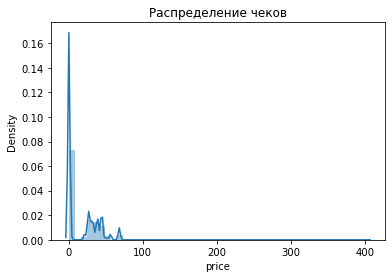

In [52]:
ax = sns.distplot(df_after.price)
ax.set(title='Распределение чеков')

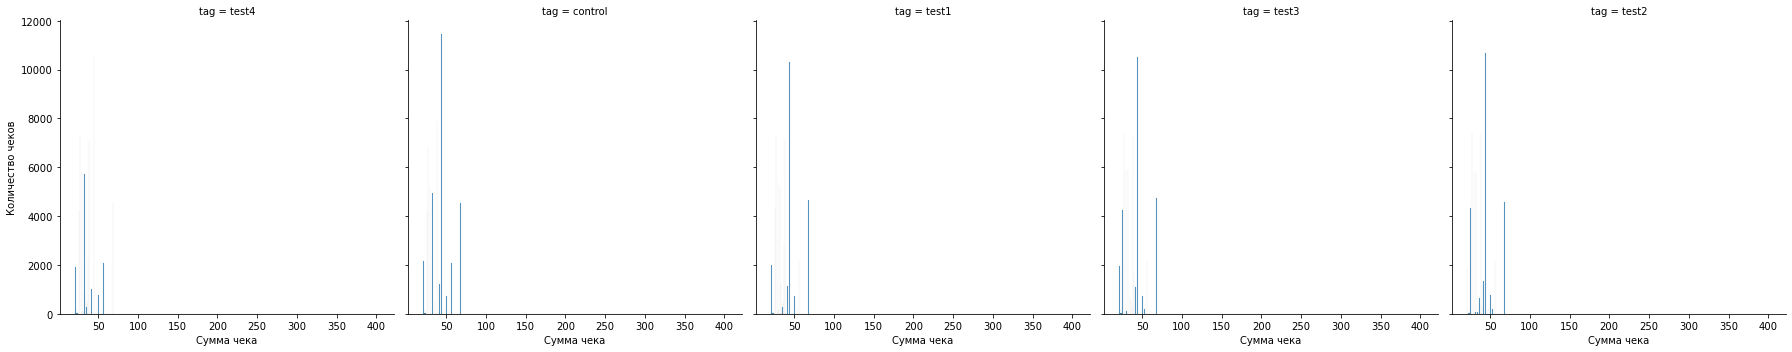

In [38]:
ax = sns.displot(df_after, x='price', col='tag')
ax.set(xlabel='Сумма чека', ylabel='Количество чеков')

In [41]:
df_after['log_price'] = np.log(df_after['price'])

[Text(0.5, 1.0, 'Распределение логарифма чеков')]

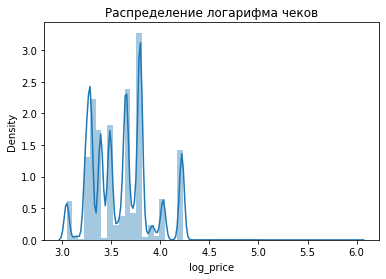

In [49]:
ax = sns.distplot(df_after.log_price)
ax.set(title='Распределение логарифма чеков')

[Text(0.5, 17.200000000000003, 'Логарифм суммы чека'),
 Text(17.200000000000003, 0.5, 'Количество чеков')]

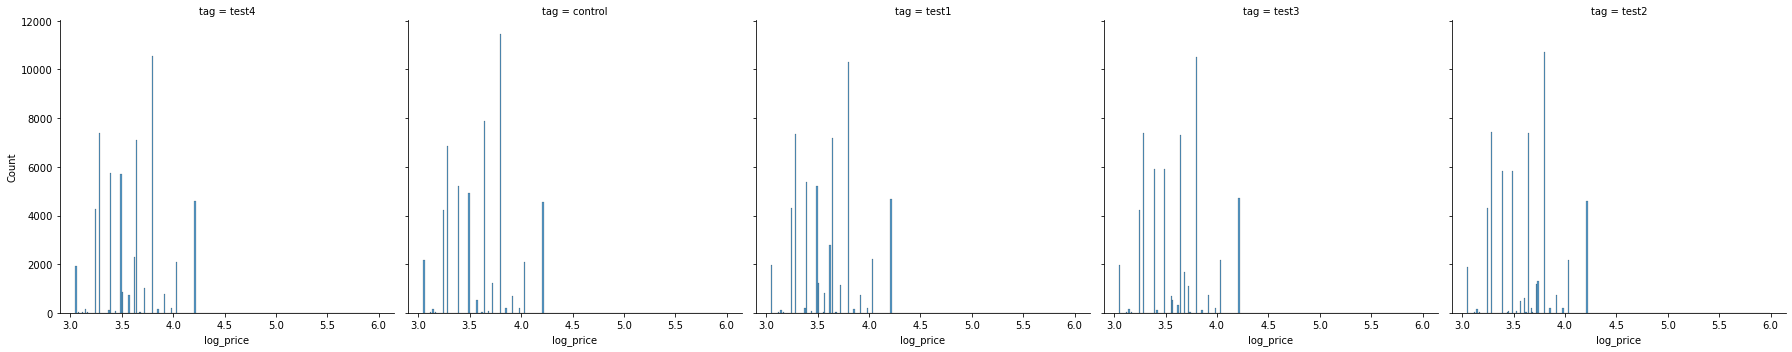

In [43]:
sns.displot(df_after, x='log_price', col='tag')
ax.set(xlabel='Логарифм суммы чека', ylabel='Количество чеков')

In [470]:
stats.shapiro(df_after.query("time > 0 and tag == 'control'").log_price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9452977180480957, pvalue=9.020404579890767e-19)

In [471]:
stats.shapiro(df_after.query("time > 0 and tag == 'test1'").log_price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9449132084846497, pvalue=7.731624098308648e-19)

In [472]:
stats.shapiro(df_after.query("time > 0 and tag == 'test2'").log_price.sample(1000, random_state=17))

ShapiroResult(statistic=0.941478431224823, pvalue=2.0168315110328507e-19)

In [473]:
stats.shapiro(df_after.query("time > 0 and tag == 'test3'").log_price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9461568593978882, pvalue=1.2767010596994308e-18)

In [474]:
stats.shapiro(df_after.query("time > 0 and tag == 'test4'").log_price.sample(1000, random_state=17))

ShapiroResult(statistic=0.9445818662643433, pvalue=6.773861135342819e-19)

In [475]:
stats.levene(df_after.query("time > 0 and tag == 'control'").log_price,
            df_after.query("time > 0 and tag == 'test1'").log_price,
            df_after.query("time > 0 and tag == 'test2'").log_price,
            df_after.query("time > 0 and tag == 'test3'").log_price,
            df_after.query("time > 0 and tag == 'test4'").log_price)

LeveneResult(statistic=22.1314235135009, pvalue=2.7262735367326688e-18)

Не соблюдаются требования ни гомогенности дисперсий, ни нормальности распределения. Используем непараметрический критерий Краскела-Уоллиса

In [476]:
stats.kruskal(df_after.query("time > 0 and tag == 'control'").price,
            df_after.query("time > 0 and tag == 'test1'").price,
            df_after.query("time > 0 and tag == 'test2'").price,
            df_after.query("time > 0 and tag == 'test3'").price,
            df_after.query("time > 0 and tag == 'test4'").price)

KruskalResult(statistic=56.504587927678244, pvalue=1.5716091893450485e-11)

Различия между группами есть. Проведем пост-хок тест Данна, чтобы понять, в каких именно группах значение отличается от контроля

In [270]:
import scikit_posthocs as sp 

In [477]:
sp.posthoc_dunn(df_after.query("time > 0"), 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000e+00,7.663195e-08,0.019353,0.001303,9.862214e-11
test1,7.663195e-08,1.000000e+00,0.014681,0.121904,5.623712e-01
test2,1.935265e-02,1.468087e-02,1.000000,0.562371,4.200755e-04
test3,1.302757e-03,1.219043e-01,0.562371,1.000000,1.084869e-02
test4,9.862214e-11,5.623712e-01,0.000420,0.010849,1.000000e+00


**Средний чек в каждой группе статистически значимо снизился.** У первой группы - на 0.9%, у второй группы - на 0.6%, у третьей группы - на 0.8%, у четвертой группы - на 1.1%

Посчитаем **ARPU** и посмотрим, отличаются ли значения статистически значимо

In [44]:
df_arpu = df_after
df_arpu['price'] = df_arpu['price'].fillna(0)

In [45]:
df_arpu = df_arpu.groupby('user_uid', as_index=False).agg({'tag': 'max', 'price': 'sum'})

[Text(0.5, 1.0, 'Распределение сумм, которые получаем от каждого пользователя')]

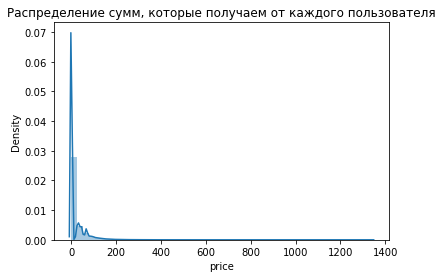

In [50]:
ax = sns.distplot(df_arpu.price)
ax.set(title='Распределение сумм, которые получаем от каждого пользователя')

In [481]:
df_arpu.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'ARPU'})

,tag,ARPU
0,control,18.561048
1,test1,19.448464
2,test2,19.348823
3,test3,19.412692
4,test4,19.313863


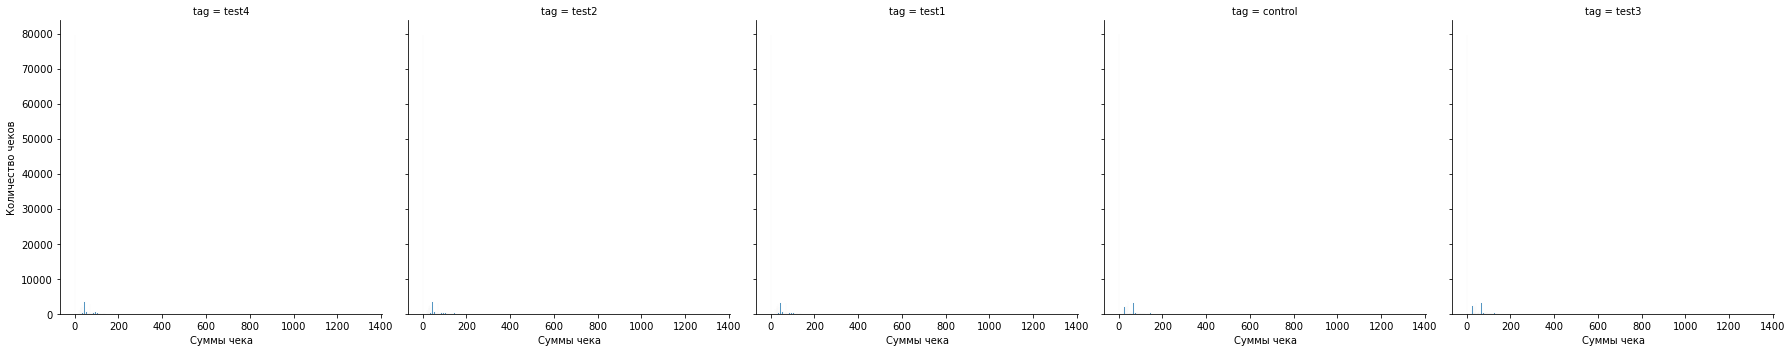

In [53]:
ax = sns.displot(df_arpu, x='price', col='tag')
ax.set(xlabel='Суммы чека', ylabel='Количество чеков')

Распределения явно отличаются от нормального, логарифмирование бессмысленно, так как логарифм нуля не определен. Проверим статистическую значимость различий непараметрическим тестом

In [483]:
stats.kruskal(df_arpu.query("tag == 'control'").price,
             df_arpu.query("tag == 'test1'").price,
             df_arpu.query("tag == 'test2'").price,
             df_arpu.query("tag == 'test3'").price,
             df_arpu.query("tag == 'test4'").price)

KruskalResult(statistic=33.596195657523204, pvalue=9.016799154999556e-07)

Отличия между граппами значимы. Посмотрим, между какими именно

In [484]:
sp.posthoc_dunn(df_arpu, 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000,0.000001,0.000595,0.000142,0.000174
test1,0.000001,1.000000,1.000000,1.000000,1.000000
test2,0.000595,1.000000,1.000000,1.000000,1.000000
test3,0.000142,1.000000,1.000000,1.000000,1.000000
test4,0.000174,1.000000,1.000000,1.000000,1.000000


**В каждой из тестовых групп ARPU выросла статистически значимо.** У первой группы - на 4.8%, у второй группы - на 4.2%, у третьей группы - на 4.6%, у четвертой группы - на 4.1%

Посмотрим на **ARPPU**

In [55]:
df_arppu = df_after.query("time > 0")

In [56]:
df_arppu = df_arppu.groupby('user_uid').agg({'tag': 'max', 'price': 'sum'})

In [487]:
df_arppu.groupby('tag', as_index=False).agg({'price': 'mean'}).rename(columns={'price': 'ARPPU'})

,tag,ARPPU
0,control,68.115792
1,test1,68.937489
2,test2,69.310454
3,test3,69.375487
4,test4,69.005958


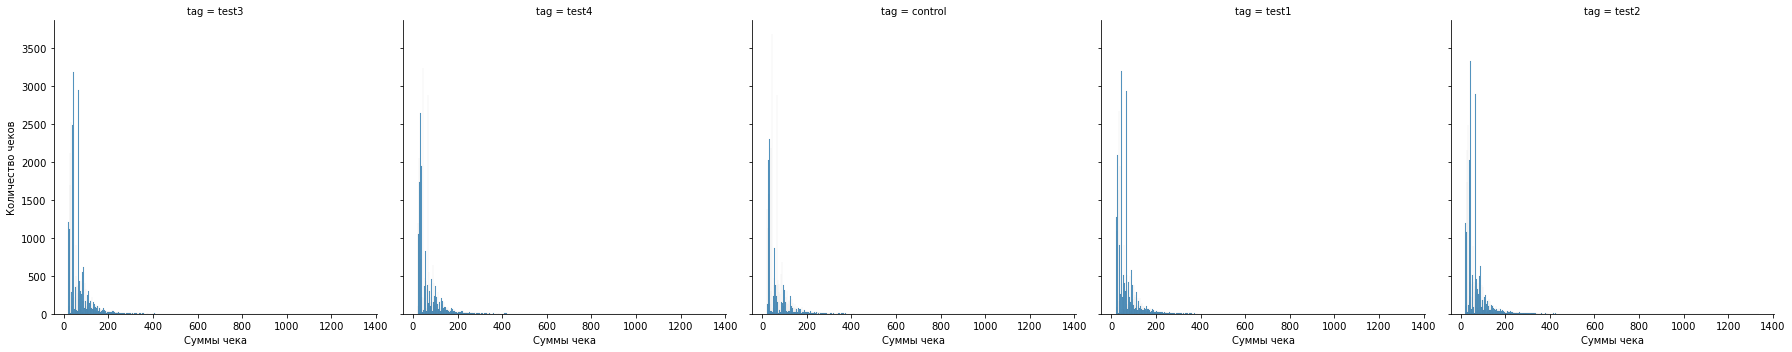

In [57]:
ax = sns.displot(df_arppu, x='price', col='tag')
ax.set(xlabel='Суммы чека', ylabel='Количество чеков')

In [489]:
stats.kruskal(df_arppu.query("tag == 'control'").price,
             df_arppu.query("tag == 'test1'").price,
             df_arppu.query("tag == 'test2'").price,
             df_arppu.query("tag == 'test3'").price,
             df_arppu.query("tag == 'test4'").price)

KruskalResult(statistic=11.29006462451837, pvalue=0.02349041631338823)

In [490]:
sp.posthoc_dunn(df_arppu, 'price', 'tag', p_adjust='holm')

,control,test1,test2,test3,test4
control,1.000000,0.453437,0.057906,0.028896,0.125168
test1,0.453437,1.000000,1.000000,1.000000,1.000000
test2,0.057906,1.000000,1.000000,1.000000,1.000000
test3,0.028896,1.000000,1.000000,1.000000,1.000000
test4,0.125168,1.000000,1.000000,1.000000,1.000000


**Значимо ARPPU вырос только для третьей тестовой группы - на 1.8%**

# Часть 4: Заключение

Выводы: 
<br>
<br>
Конверсия выросла во всех группах. В первой группе - на 3.5%, во второй группе - на 2.4%, в третьей группе - на 2.7%, в четвертой группе - на 2.7%
<br>
<br>
Конверсия в повторную покупку выросла. У первой группы - на 3.9%, у второй группы - на 4.4%, у третьей группы - на 4.3%, у четвертой - на 5.4%
<br>
<br>
Конверсия в покупку контента выросла. У первой группы - на 10.5%, у второй группы - на 8.2%, у третьей группы - на 9.8%, у четвертой группы - на 12.6%. В другие типы транзакций - не изменилась (для всех групп)
<br>
<br>
Средний чек снизился в каждой группе. У первой группы - на 0.9%, у второй группы - на 0.6%, у третьей группы - на 0.8%, у четвертой группы - на 1.1%
<br>
<br>
ARPU выросла в каждой группе. У первой группы - на 4.8%, у второй группы - на 4.2%, у третьей группы - на 4.6%, у четвертой группы - на 4.1%
<br>
<br>
ARPPU выросла только в третьей группе на 1.8%. 

Каких данных не хватает: 
<br>
<br>
1) реальных данных по дате, чтобы посчитать удержание;
<br>
<br>
2) типа подписки (месячная, полугодовая, годовая), чтобы посмотреть динамику конверсий в них; 
<br>
<br>
3) данных по удовлетворенностью новой системы оплаты, чтобы посчитать CSI